# Intro
This is the jupyter notebook containing all code relevant to auxiliary code for the BiG-SCAPE 2.0 thesis project

Start by importing these modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import plots.hist

import data
import truth.truth as truth
import input.paths as paths
import input.bigslice_hmm

import predictions
import predictions.tests

import validation

from sklearn.metrics.pairwise import cosine_similarity

The following code instantiates any relevant paths to data or output. Make sure to change these for your purposes.
Not all the paths may be relevant, e.g. if you are using the bigscape_distances.tsv that is included in this repository.

In [2]:

# location of the core and bio pfam information tab separated files.
# these are included in this repository, but if you want to get them from BiG-SLICE directly point them to their respective locations
CORE_PFAM_TSV = "corepfam.tsv"
BIO_PFAM_TSV = "biopfam.tsv"
# location of the full bigscape distances tab separated file.
# this file is created if you are loading new values from a run using the path after this one
FULL_TSV = "bigscape_distances.tsv"
# Base folder of Cluster files generated by BiG-SCAPE for a run. e.g:
BIGSCAPE_CLUSTER_FILES = "D:/Temp/2022-03-22_09-18-06_hybrids_global"

# location of the sqlite database to analyze
SQLITE_DB = "D:/Temp/data-benchmark-100.db"


The following code loads data from a BiG-SCAPE run. Point the RUN_PATH to a BiG-SCAPE result folder and it will collect all BGC pair distances
It will then save these distances to the bigscape_distances.tsv file indicated by the FULL_TSV path above

If you want to recreate the bigscape_distances.tsv, run BiG-SCAPE 2.0 on the closed streptomyces dataset provided here:
https://zenodo.org/record/1532752/files/Closed_Streptomyces_antiSMASH_results.zip?download=1
and run using bigscape.py --i /path/to/streptomyces -o ~/bigscape-streptomyces-output --cutoff 1.0
then run the following code block

In [ ]:
TRUTH_DISTANCES = truth.get_distances_from_results(BIGSCAPE_CLUSTER_FILES, "1.00")
truth.write_full_file(FULL_TSV, TRUTH_DISTANCES)

Otherwise, just run the below code block to load the ground truth for validation

In [4]:
print("Loading truth")
# load truth values
TRUTH_DISTANCES = truth.from_file(FULL_TSV)

TRUTH_PAIRS = validation.pairs_from_distances(TRUTH_DISTANCES)

print("Loading stored info from database")
DB = data.Database(SQLITE_DB)

BGC_IDS = data.get_bgc_ids(DB)
HMM_IDS = data.get_hmm_ids(DB)

BGC_ID_NAME_DICT = data.get_bgc_id_name_dict(DB)
BGC_NAME_ID_DICT = {name: id for id, name in BGC_ID_NAME_DICT.items()}

CORE_PFAM_ACC, CORE_PFAM_NAMES = input.bigslice_hmm.get_core_pfam(CORE_PFAM_TSV)
BIO_PFAM_ACC, BIO_PFAM_NAMES = input.bigslice_hmm.get_bio_pfam(BIO_PFAM_TSV)
# get corresponding ids
CORE_PFAM_IDS = data.get_core_pfam_ids(DB, CORE_PFAM_ACC, CORE_PFAM_NAMES)
BIO_PFAM_IDS = data.get_bio_pfam_ids(DB, BIO_PFAM_ACC, BIO_PFAM_NAMES)
CORE_PFAM_SET = set(CORE_PFAM_IDS)
BIO_PFAM_SET = set(BIO_PFAM_IDS)
print("Done")


Loading truth
Loading stored info from database
Done


First bit of data exploration: show a histogram of values in the truth data.
This gives a general idea of how the true distances are distributed

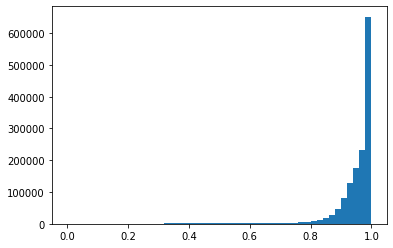

In [9]:
# show hist of true distances
plots.hist.from_distances(TRUTH_DISTANCES, max=len(TRUTH_DISTANCES), bins=50)

What this shows is that the vast majority of distances in the ground truth are way beyond the default BiG-SCAPE cutoff of 0.3
In turn this means that the vast majority of BGCs are unrelated, and if we can filter these out before we run BiG-SCAPE's pairwise distance calculation we can gain a lot of time

We are trying to use the fast calculation of BiG-SLICE features to thin out the crowd of BGC comparisons.
We will load the data into a format that can be used by skilearn, which we're using for most analyses

In [5]:

print("Instantiating dataframes")
# instantiate dataframes
FEATURES = pd.DataFrame(
    np.zeros((len(BGC_IDS), len(HMM_IDS)), dtype=np.uint8),
    index=BGC_IDS,
    columns=HMM_IDS
)

# fetch feature values from db
BGC_HMM_FEATURES = data.get_features(DB)
for bgc_id, hmm_id, value in BGC_HMM_FEATURES:
    FEATURES.at[bgc_id, hmm_id] = value
print("Done")

Instantiating dataframes
Done


We want to know more about what this data looks like. It probably helps to get data labels based on truth for visualisation if we want to do it.
We get a label set based on the distances. This probably isn't super accurate but it will give us a general idea of which data points belong together.
The labels are assembled by going through all distances and assigning pairs with distance < 0.3 to a label
If later on there is a pair where BGC A already has a label, it will set or overwrite BGC B's label with that of BGC A.
The same goes for if there is already a label set on BGC B. It will then set the label of BGC A to that of BGC B.

IF the total number of pairs / 2 is larger than the total number of BGCs, this will overwrite labels. Thus this is probably not super accurate. This data is also missing the initial separation of bgcs due to product type classification

In [6]:
# get a dataframe of labels associated with each BGC based on truth
# this means a dataframe of bgcs where bgcs with a distance of < 0.3 belong to
# the same 'cluster'
TRUTH_LABELS = validation.labels_from_distances(TRUTH_DISTANCES, BGC_NAME_ID_DICT, BGC_IDS)

LABEL_LIST = [TRUTH_LABELS.at[bgc_id,"label"] for bgc_id in BGC_IDS]
print("Found", max(TRUTH_LABELS["label"]), " labels")
# check how this measures up to the pairs in the truth data
classified = len(list(filter(lambda item: item > 0, LABEL_LIST)))
unclassified = len(LABEL_LIST) - classified
print(classified, "BGCs are labeled")
print(unclassified, "BGCs are unlabeled")
PAIRED_BGCS = set()
for pair in TRUTH_PAIRS[0]:
    PAIRED_BGCS.add(pair[0])
    PAIRED_BGCS.add(pair[1])
print(len(PAIRED_BGCS), "BGCs are actually paired")

Found 601  labels
1669 BGCs are labeled
1313 BGCs are unlabeled
1669 BGCs are actually paired


We might want to consider the features generated from core domains and biosynthetic domains seperately. There are a few ways to do this but the easiest is to make some sort of sum of the features in these two classes and create a two-dimensional data frame.

In [7]:
# this dataframe contains sums of features from biosynthetic pfams and core pfams separately
SUMS_CORE = pd.DataFrame(FEATURES[CORE_PFAM_IDS].sum(axis=1), columns=["sum_core"])
SUMS_BIO = pd.DataFrame(FEATURES[BIO_PFAM_IDS].sum(axis=1), columns=["sum_bio"])
FEATURES_SUMS = pd.merge(SUMS_CORE, SUMS_BIO, left_index=True, right_index=True)

We can look at what this data looks like using the labels from earlier

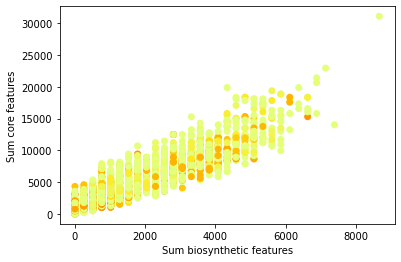

In [8]:
# show a plot of how this data looks lke
plt.xlabel("Sum biosynthetic features")
plt.ylabel("Sum core features")
plt.scatter(FEATURES_SUMS["sum_core"], FEATURES_SUMS["sum_bio"], c=LABEL_LIST, cmap="Wistia")
plt.show()

This doesn't show any clear separation of pairs using this. Then again, it's hard to tell since there are quite a lot of labels.

It's unlikely that simple summation of data is a good method of reducing dimensionality.
If we need to we can return to reducing dimensionality later

For now we will look at some things we can do in a higher dimensional space. Starting simple with euclidean distance calculation. The following calculates euclidean distances on all rows and features and plots the distances calculated in a histogram.

This is using all entries, so it may take some time.

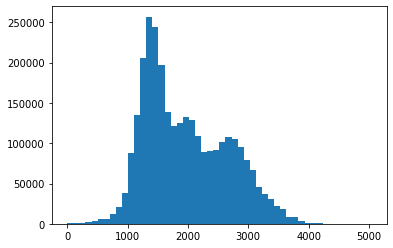

In [14]:
EUCLIDEAN_DISTS = predictions.get_distances(FEATURES, BGC_ID_NAME_DICT, metric="euclidean")
plots.hist.from_distances(EUCLIDEAN_DISTS, max=None, bins=50)

This graph does not correspnd well at all to the graph we got earlier, so there's no reason to think euclidean distances will perform well as a cutoff
Still, we can try. We can explore some cutoff tresholds and see what happens
In this case we will try invervals of 200 starting at 1000, and ending at 3000

In [29]:
predictions.tests.distance.run_upper(
    EUCLIDEAN_DISTS,
    TRUTH_PAIRS,
    upper_range=10,
    upper_cutoff_step=200,
    upper_cutoff_start=1000
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
1000,0,2338752,45898,NA,0.0,1.0,0.995,NA,0.995,0,0,498891,2620
1200,0,2236930,147720,NA,0.0,1.0,0.995,NA,0.995,0,0,477480,2481
1400,0,2000448,384202,NA,0.0,1.0,0.995,NA,0.995,0,0,427022,2163
1600,0,1695393,689257,NA,0.0,1.0,0.995,NA,0.995,0,0,361021,1811
1800,0,1443159,941491,NA,0.0,1.0,0.995,NA,0.995,0,0,303341,1554
2000,0,1197316,1187334,NA,0.0,1.0,0.995,NA,0.995,0,0,252185,1297
2200,0,960214,1424436,NA,0.0,1.0,0.995,NA,0.995,0,0,204094,1028
2400,0,793047,1591603,NA,0.0,1.0,0.995,NA,0.995,0,0,168316,877
2600,0,624307,1760343,NA,0.0,1.0,0.995,NA,0.995,0,0,133052,689
2800,0,428750,1955900,NA,0.0,1.0,0.995,NA,0.995,0,0,92084,480


From the looks of it the ratio of true negative to false negative remains the same, so it seems we are arbitrarily eliminating pairs doing this.  
we will have to find a better way of eliminating pairs than calculating a simple euclidean distance

We can try a different metric, like cosine similarity

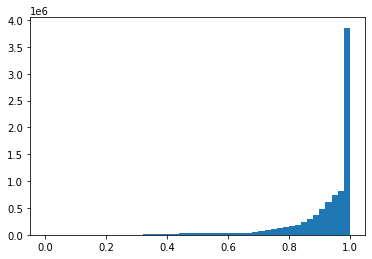

In [6]:
COSINE_DISTS = predictions.get_cosine_distance(FEATURES.replace({np.nan: 0}), BGC_ID_NAME_DICT)
# plot
plots.hist.from_distances(COSINE_DISTS, max=None, bins=50)

This looks a lot more similar to the truth distances calculated earlier. let's see how they measure up

In [9]:
predictions.tests.distance.run_upper(
    COSINE_DISTS,
    TRUTH_PAIRS,
    upper_range=7,
    upper_cutoff_step=0.1,
    upper_cutoff_start=0.4
)

Predictions from distances (upper only):
cut_upp,under,over,unclass,prec,sens,spec,acc,ppv,npv,tp,fp,tn,fn
0.4,0,4402201,45452,NA,0.0,1.0,0.995,NA,0.995,0,0,939371,4791
0.5,0,4336027,111626,NA,0.0,1.0,0.995,NA,0.995,0,0,924806,4726
0.6000000000000001,0,4237225,210428,NA,0.0,1.0,0.995,NA,0.995,0,0,903945,4603
0.7000000000000001,0,4133990,313663,NA,0.0,1.0,0.995,NA,0.995,0,0,881923,4471
0.8,0,3869045,578608,NA,0.0,1.0,0.995,NA,0.995,0,0,824079,4168
0.9,0,3247464,1200189,NA,0.0,1.0,0.995,NA,0.995,0,0,692192,3493
1.0,0,1828067,2619586,NA,0.0,1.0,0.995,NA,0.995,0,0,392681,2048


Similar to the euclidean distance cutoffs, no great success here.

The results may be skewed by the presence of a large amount of zeros in the matrix.  
We can check this by plotting the length of domains (which should relate to number of features > 0) to the distances  
There should be some sort of correlation

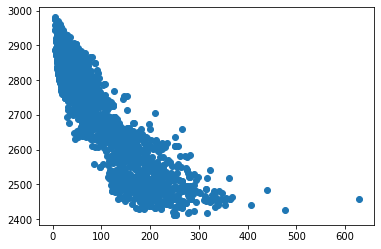

In [32]:
FEATURES_COUNTS = pd.DataFrame(FEATURES.replace({0: np.nan}).count(axis=1), columns=["domain_count"])
COSINE_DISTS = 1 - cosine_similarity(FEATURES)
DIST_SUMS = pd.DataFrame(COSINE_DISTS.mean(axis=1), columns=["sum_dist"])
FEATURES_COUNTS[0:10]
plt.scatter(FEATURES_COUNTS, DIST_SUMS)